# 🪄 Harry Potter Fan Fiction Logistic Regression Analysis

## Learning Objectives

In this notebook, you'll learn to:
- Build logistic regression models with **interaction terms** (capturing how variables work together)
- Create **polynomial terms** (quadratic) to model non-linear relationships
- Compare **StatsModels** and **scikit-learn** approaches to logistic regression
- Interpret model coefficients and assess model performance
- Understand how complex relationships in data can be captured through feature engineering

## Dataset Overview

We're working with a cleaned subset of Harry Potter fan fiction data from [fanfiction.net](https://www.fanfiction.net/book/Harry-Potter/). The dataset contains:

**Quantitative Variables:**
- `words` - Number of words in the story
- `reviews` - Number of reviews the story received
- `favorites` - Number of readers who favorited the story
- `follows` - Number of readers who follow the story

**Binary Categorical Variables (1 = True, 0 = False):**
- `harry` - Harry is a character in the story
- `hermione` - Hermione is a character in the story
- `multiple` - The story has multiple chapters
- `english` - The story is in English
- `humor` - The story's genre is humor

**Goal:** Predict whether a fan fiction story is "popular" based on its characteristics using logistic regression with interaction and polynomial terms.


## Phase 1: Setup and Imports

First, let's import all the libraries we'll need for this analysis.


In [53]:
# TODO: Import all necessary libraries
# Hint: You'll need pandas for data manipulation, numpy for numerical operations,
# matplotlib and seaborn for visualization, statsmodels for logistic regression,
# and sklearn for additional modeling and evaluation tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc



## Phase 2: Data Loading and Initial Exploration

Understanding your data is the foundation of any good analysis. Let's start by loading the dataset and getting familiar with its structure.


In [54]:
# TODO: Load the Harry Potter fan fiction dataset
# Hint: Use pandas' read_csv() function to load 'hp.csv' from the data directory
# Store the result in a variable called 'hp'

# Write your code here:
import kagglehub
from dotenv import load_dotenv
import os

load_dotenv()

KAGGLE_USERNAME = os.getenv("KAGGLE_USERNAME")
KAGGLE_KEY = os.getenv("KAGGLE_KEY")



# Download the dataset to ../data folder
path = kagglehub.dataset_download("nehatiwari03/harry-potter-fanfiction-data")
print("path to the files:", path)

# Ensure all files are consolidated inside the ../data folder
import shutil

data_folder = "../data"
os.makedirs(data_folder, exist_ok=True)

# Move all downloaded files into the ../data directory
for fname in os.listdir(path):
    src = os.path.join(path, fname)
    dst = os.path.join(data_folder, fname)
    if os.path.isfile(src):
        shutil.move(src, dst)

data_path = data_folder



# Load the dataset
hp = pd.read_csv("../data/hpcleanvlarge1.csv")

# Display the first few rows of the dataset
print(hp.head())


path to the files: /Users/franciscoteixeirabarbosa/.cache/kagglehub/datasets/nehatiwari03/harry-potter-fanfiction-data/versions/1
   Chapters Favs Follows    Published  Reviews Updated    Words  \
0         1    2     NaN   12/31/2019      1.0     NaN    6,840   
1         1    1     NaN   12/31/2019      NaN     NaN   10,962   
2         1    3       2   12/31/2019      NaN     NaN    8,592   
3         2  NaN     NaN   12/31/2019      NaN     NaN    7,260   
4         1    4       3   12/31/2019      NaN     NaN    1,529   

              author                                   characters  \
0            reviews    Sirius B., Remus L., James P., Regulus B.   
1           JoyI9199  Harry P., Draco M., Narcissa M., Charlie W.   
2  MoonytheMarauder1                       [James P., Regulus B.]   
3        LaviniaKatt                                    Cedric D.   
4   Rowena-Moon-Moon                                          NaN   

                genre language rating  \
0  Angst/Hu

In [55]:
# TODO: Display the first few rows of the dataset
# Hint: Use the .head() method to see the first 5 rows

# Write your code here:
hp.head()

,Chapters,Favs,Follows,Published,Reviews,Updated,Words,author,characters,genre,language,rating,story_link,synopsis,title,published_mmyy,pairing
0,1,2,NaN,12/31/2019,1.0,NaN,"6,840",reviews,"Sirius B., Remus L., James P., Regulus B.",Angst/Hurt/Comfort,English,T,https://www.fanfiction.net/s/13466909/1/If-You...,Regulus and James aren't happy. They know they...,If You Change Your Mind,12-2019,NaN
1,1,1,NaN,12/31/2019,NaN,NaN,"10,962",JoyI9199,"Harry P., Draco M., Narcissa M., Charlie W.",Angst/Drama,English,M,https://www.fanfiction.net/s/13466894/1/Bloody...,When a plot from the Founder's age is revealed...,Bloody Ballgowns,12-2019,NaN
2,1,3,2,12/31/2019,NaN,NaN,"8,592",MoonytheMarauder1,"[James P., Regulus B.]",Angst,English,M,https://www.fanfiction.net/s/13466885/1/Nothin...,"Regulus Black is supposed to be dead, but he's...",Nothing Left To Do,12-2019,"James P., Regulus B."
3,2,NaN,NaN,12/31/2019,NaN,NaN,"7,260",LaviniaKatt,Cedric D.,Romance/Fantasy,English,M,https://www.fanfiction.net/s/13466880/1/Patien...,This is a spin off of Harry Potter taking plac...,Patience is a Virtue,12-2019,NaN
4,1,4,3,12/31/2019,NaN,NaN,"1,529",Rowena-Moon-Moon,NaN,NaN,English,T,https://www.fanfiction.net/s/13466807/1/An-Und...,Harry makes a new discovery and perhaps a few ...,An Understanding,12-2019,NaN


In [56]:
# TODO: Check the shape and basic info about the dataset
# Hint: Use .shape to see dimensions and .info() to see data types

# Write your code here:
print("Shape of the dataset:", hp.shape)
print("Basic info about the dataset:")
hp.info()
print(hp.dtypes)

# Coverting some objects to integers
# Even more robust approach
def clean_numeric_column(series, remove_commas=True):
    """Clean and convert a series to numeric"""
    # Convert to string first
    str_series = series.astype(str)
    
    # Remove commas if requested
    if remove_commas:
        str_series = str_series.str.replace(',', '')
    
    # Convert to numeric, coercing errors to NaN
    return pd.to_numeric(str_series, errors='coerce')

# Apply the cleaning function
hp['Words_clean'] = clean_numeric_column(hp['Words'], remove_commas=True)
hp['Favs_clean'] = clean_numeric_column(hp['Favs'], remove_commas=False)
hp['Follows_clean'] = clean_numeric_column(hp['Follows'], remove_commas=False)
hp['Reviews_clean'] = clean_numeric_column(hp['Reviews'], remove_commas=False)

# Verify the cleaning worked
print("Original data types:")
print(hp[['Words', 'Favs', 'Follows', 'Reviews']].dtypes)
print("\nCleaned data types:")
print(hp[['Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean']].dtypes)
print("\nSample of cleaned data:")
print(hp[['Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean']].head())

Shape of the dataset: (648493, 17)
Basic info about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648493 entries, 0 to 648492
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Chapters        648493 non-null  int64  
 1   Favs            576330 non-null  object 
 2   Follows         505289 non-null  object 
 3   Published       648493 non-null  object 
 4   Reviews         596304 non-null  float64
 5   Updated         238265 non-null  object 
 6   Words           648493 non-null  object 
 7   author          648493 non-null  object 
 8   characters      585453 non-null  object 
 9   genre           588566 non-null  object 
 10  language        648493 non-null  object 
 11  rating          648493 non-null  object 
 12  story_link      648493 non-null  object 
 13  synopsis        648482 non-null  object 
 14  title           648477 non-null  object 
 15  published_mmyy  648493 non-null  obje

In [57]:
# TODO: Check for missing values
# Hint: Use .isnull().sum() to count missing values in each column

# Write your code here:
print("Missing or no valid values:")
print(hp.isnull().sum())

Missing or no valid values:
Chapters               0
Favs               72163
Follows           143204
Published              0
Reviews            52189
Updated           410228
Words                  0
author                 0
characters         63040
genre              59927
language               0
rating                 0
story_link             0
synopsis              11
title                 16
published_mmyy         0
pairing           256823
Words_clean            0
Favs_clean         77386
Follows_clean     147324
Reviews_clean      52189
dtype: int64


In [58]:
# TODO: Generate descriptive statistics for all variables
# Hint: Use .describe() to get summary statistics like mean, median, std, etc.

# Write your code here:
print("Description for all the variables:")
print(hp.describe())

Description for all the variables:
            Chapters        Reviews   Words_clean     Favs_clean  \
count  648493.000000  596304.000000  6.484930e+05  571107.000000   
mean        4.180192      36.752712  1.053018e+04      38.609434   
std         8.499502     202.629776  3.244711e+04      95.187804   
min         1.000000       1.000000  0.000000e+00       1.000000   
25%         1.000000       3.000000  9.630000e+02       3.000000   
50%         1.000000       7.000000  2.177000e+03       9.000000   
75%         4.000000      19.000000  6.731000e+03      28.000000   
max       542.000000   38111.000000  3.315736e+06     999.000000   

       Follows_clean  Reviews_clean  
count  501169.000000  596304.000000  
mean       33.640277      36.752712  
std        90.995433     202.629776  
min         1.000000       1.000000  
25%         2.000000       3.000000  
50%         6.000000       7.000000  
75%        21.000000      19.000000  
max       999.000000   38111.000000  


## Phase 3: Exploratory Data Analysis (EDA)

Exploratory Data Analysis is crucial before building any model. It helps us understand patterns, relationships, and potential issues in our data. This understanding will guide our feature engineering decisions.


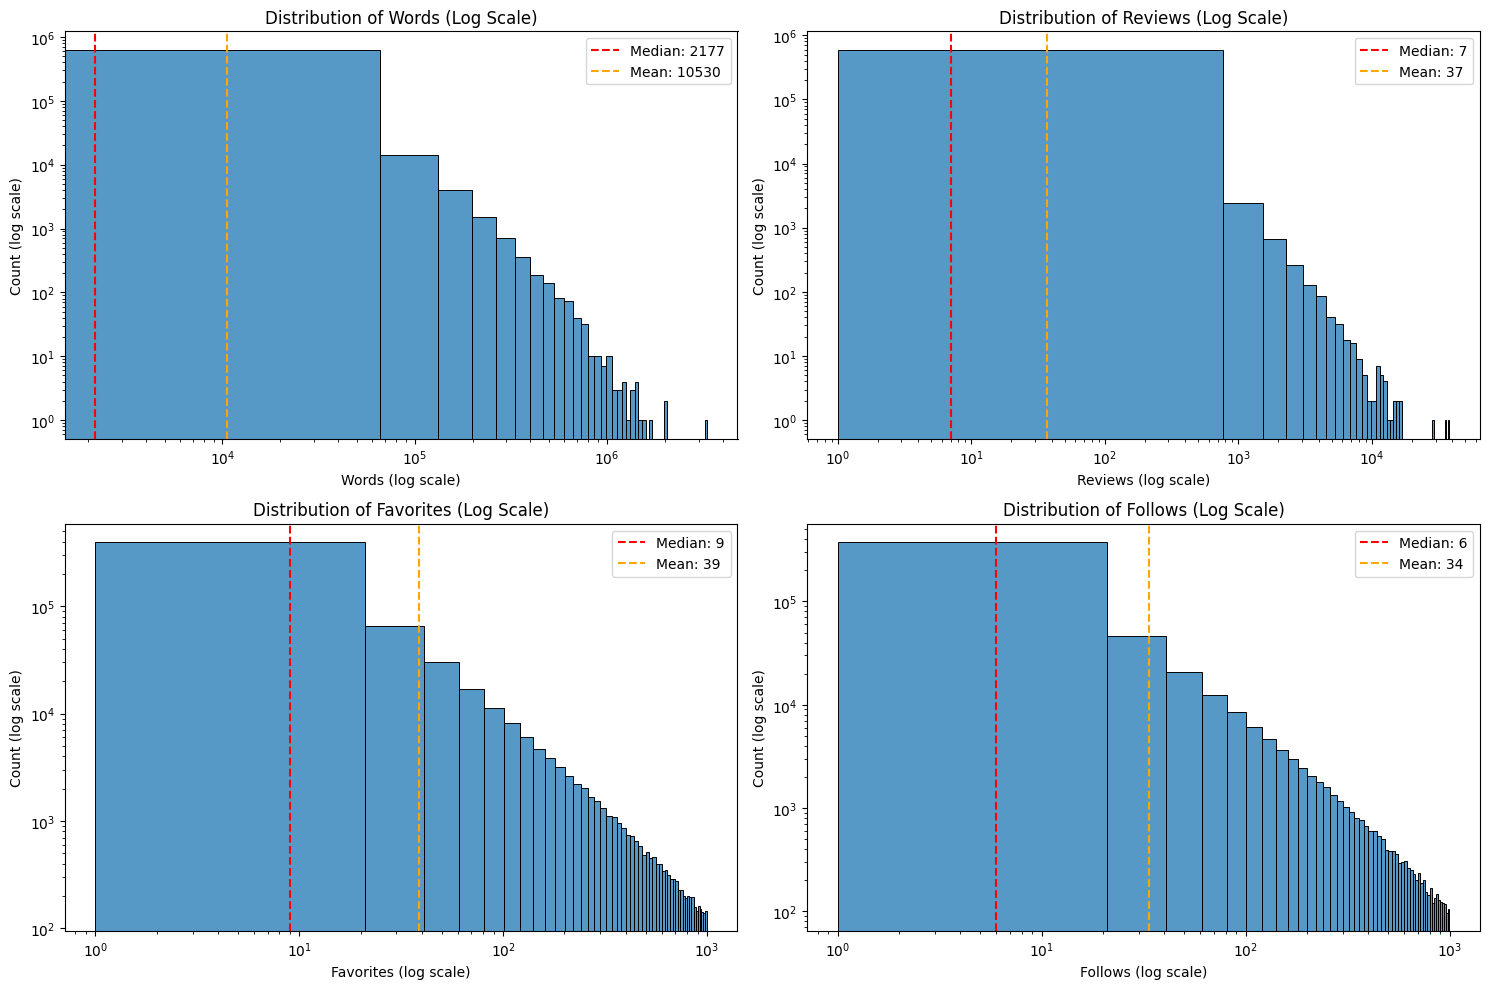

In [59]:
# TODO: Create distribution plots for quantitative variables
# Plot distributions for: words, reviews, favorites, follows
# We'll use subplots for better visualization

# Create distribution plots with log scale for better insight
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

quant_vars = ['Words_clean', 'Reviews_clean', 'Favs_clean', 'Follows_clean']
var_names = ['Words', 'Reviews', 'Favorites', 'Follows']

for i, (var, name) in enumerate(zip(quant_vars, var_names)):
    data = hp[var].dropna()
    
    # Use log scale for better visualization of skewed data
    sns.histplot(data, bins=50, ax=axes[i])
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_title(f'Distribution of {name} (Log Scale)')
    axes[i].set_xlabel(f'{name} (log scale)')
    axes[i].set_ylabel('Count (log scale)')
    
    # Add summary statistics
    median_val = data.median()
    mean_val = data.mean()
    axes[i].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.0f}')
    axes[i].axvline(mean_val, color='orange', linestyle='--', label=f'Mean: {mean_val:.0f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Binary variables created:
harry: 187,089 stories (28.8%)
hermione: 158,485 stories (24.4%)
ron: 40,249 stories (6.2%)
draco: 143,247 stories (22.1%)
multiple: 254,716 stories (39.3%)
english: 506,057 stories (78.0%)
humor: 128,596 stories (19.8%)


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_89686/3897906924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hp, x=var, ax=axes[i], palette='viridis')
/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_89686/3897906924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hp, x=var, ax=axes[i], palette='viridis')
/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_89686/3897906924.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=hp, x=var, ax=axes[i], palette='viridis')
/var/folders/

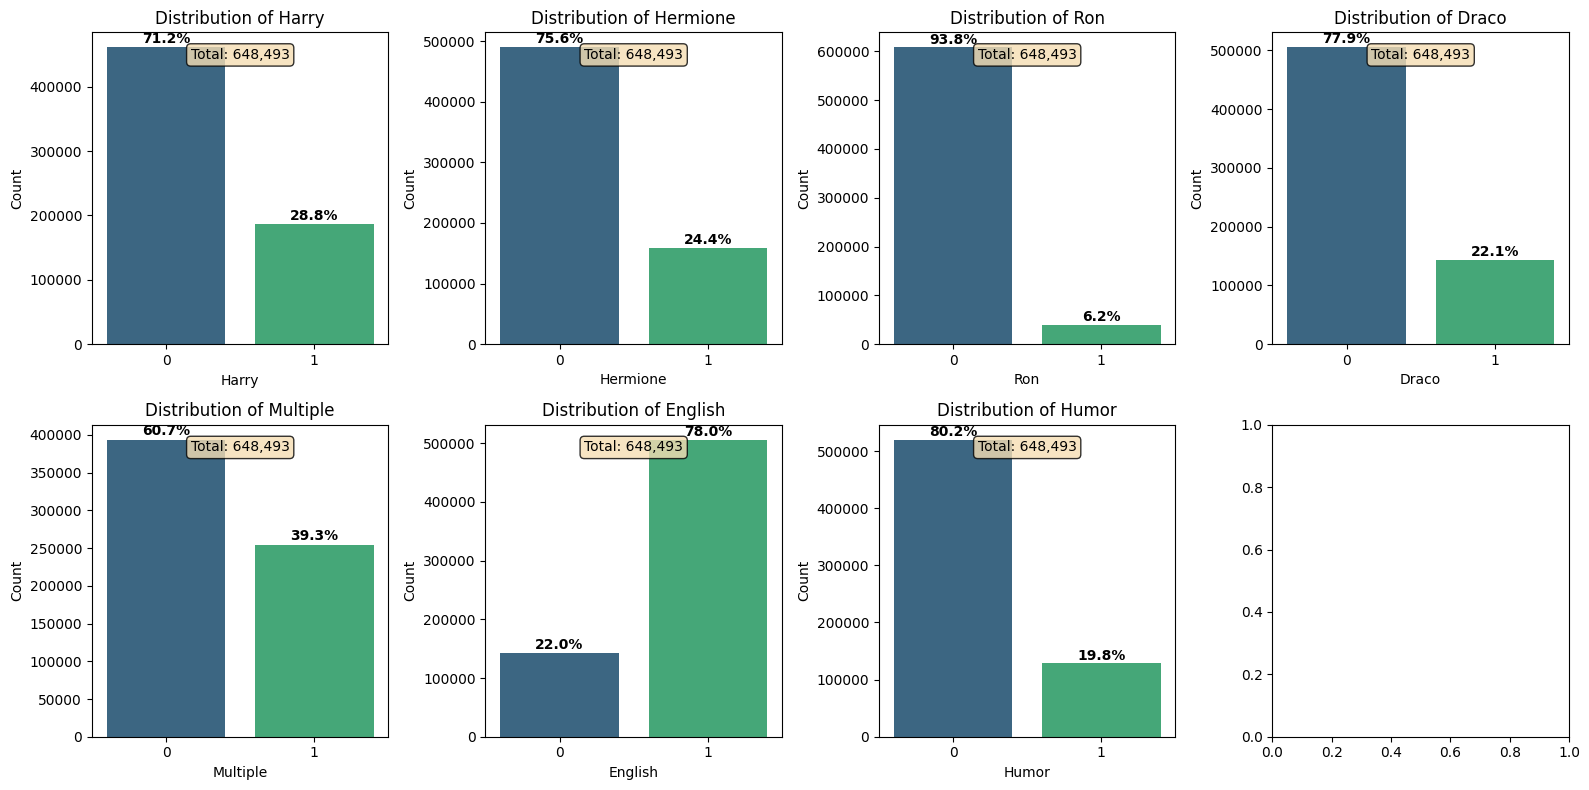

Binary Variables Summary:
   Variable  Count_Yes  Count_No  Percentage_Yes  Percentage_No
0     harry     187089    461404            28.8           71.2
1  hermione     158485    490008            24.4           75.6
2       ron      40249    608244             6.2           93.8
3     draco     143247    505246            22.1           77.9
4  multiple     254716    393777            39.3           60.7
5   english     506057    142436            78.0           22.0
6     humor     128596    519897            19.8           80.2


In [60]:
# TODO: Create count plots for binary categorical variables
# Hint: Use seaborn's countplot() to show the distribution of 0s and 1s
# Plot for: harry, hermione, multiple, english, humor

# Create binary variables for main characters
hp['harry'] = hp['characters'].astype(str).str.contains('Harry', case=False, na=False).astype(int)
hp['hermione'] = hp['characters'].astype(str).str.contains('Hermione', case=False, na=False).astype(int)
hp['ron'] = hp['characters'].astype(str).str.contains('Ron', case=False, na=False).astype(int)
hp['draco'] = hp['characters'].astype(str).str.contains('Draco', case=False, na=False).astype(int)

# Create other useful binary variables
hp['multiple'] = (hp['Chapters'] > 1).astype(int)
hp['english'] = (hp['language'] == 'English').astype(int)
hp['humor'] = hp['genre'].astype(str).str.contains('Humor|Comedy', case=False, na=False).astype(int)

# Check what we created
print("Binary variables created:")
binary_vars = ['harry', 'hermione', 'ron', 'draco', 'multiple', 'english', 'humor']
for var in binary_vars:
    print(f"{var}: {hp[var].sum():,} stories ({hp[var].mean()*100:.1f}%)")

# Count plots for binary variables
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, var in enumerate(binary_vars):
    if i < len(axes):
        # Create count plot
        sns.countplot(data=hp, x=var, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {var.title()}')
        axes[i].set_xlabel(var.title())
        axes[i].set_ylabel('Count')
        
        # Add percentages on bars
        total = len(hp)
        for j, p in enumerate(axes[i].patches):
            height = p.get_height()
            percentage = (height/total)*100
            axes[i].text(p.get_x() + p.get_width()/2., height + total*0.01,
                        f'{percentage:.1f}%', ha='center', fontweight='bold')
        
        # Add total count
        axes[i].text(0.5, 0.95, f'Total: {total:,}', transform=axes[i].transAxes, 
                    ha='center', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Create a summary table
binary_summary = pd.DataFrame({
    'Variable': binary_vars,
    'Count_Yes': [hp[var].sum() for var in binary_vars],
    'Count_No': [len(hp) - hp[var].sum() for var in binary_vars],
    'Percentage_Yes': [hp[var].mean()*100 for var in binary_vars],
    'Percentage_No': [(1-hp[var].mean())*100 for var in binary_vars]
})

print("Binary Variables Summary:")
print(binary_summary.round(1))

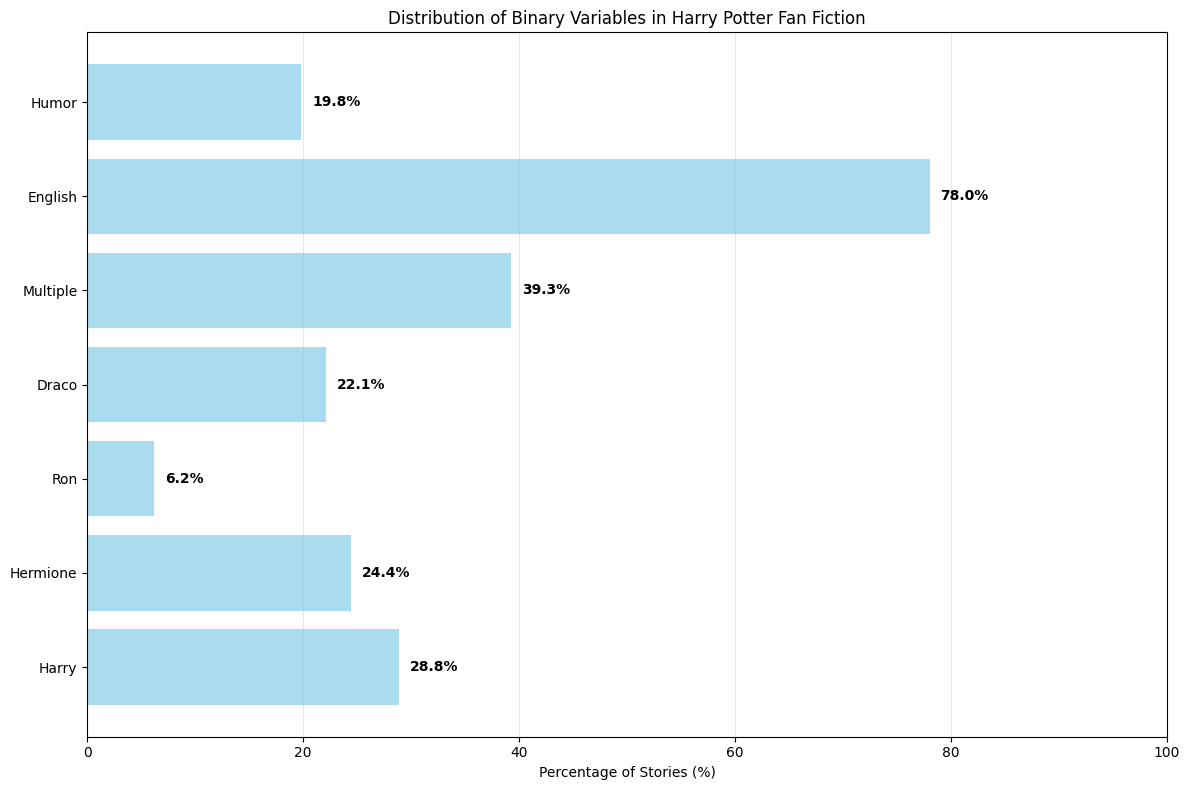

In [61]:
# One comprehensive plot showing all binary variables
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data
y_pos = np.arange(len(binary_vars))
percentages = [hp[var].mean()*100 for var in binary_vars]

# Create horizontal bar plot
bars = ax.barh(y_pos, percentages, color='skyblue', alpha=0.7)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels([var.title() for var in binary_vars])
ax.set_xlabel('Percentage of Stories (%)')
ax.set_title('Distribution of Binary Variables in Harry Potter Fan Fiction')
ax.set_xlim(0, 100)

# Add percentage labels
for i, (bar, pct) in enumerate(zip(bars, percentages)):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', ha='left', va='center', fontweight='bold')

# Add grid
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Quantitative variables for scatter plots: ['Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean']


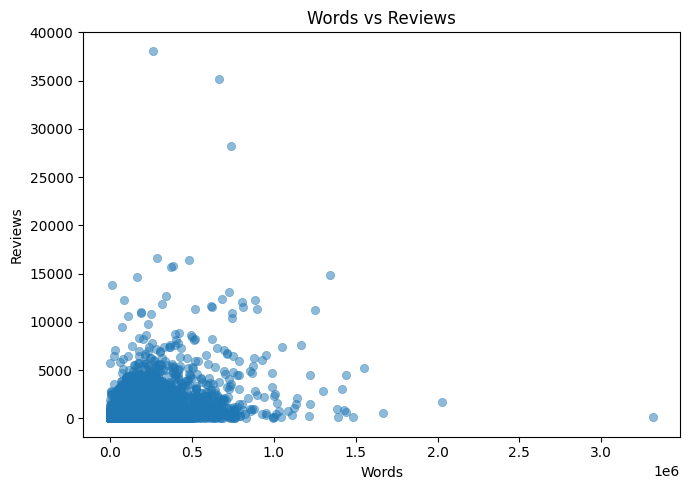

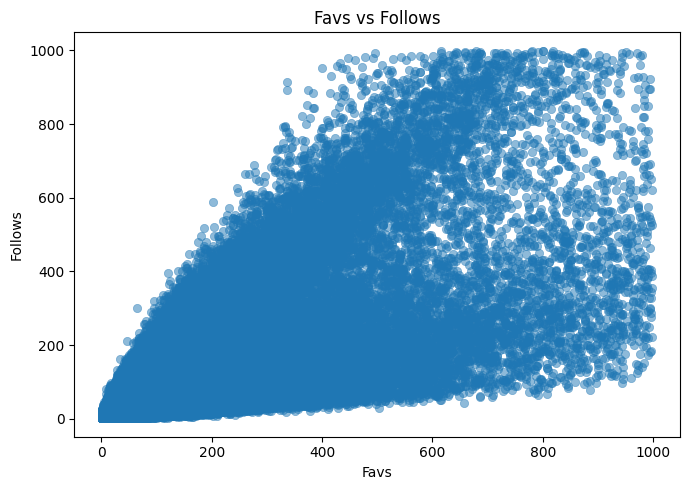

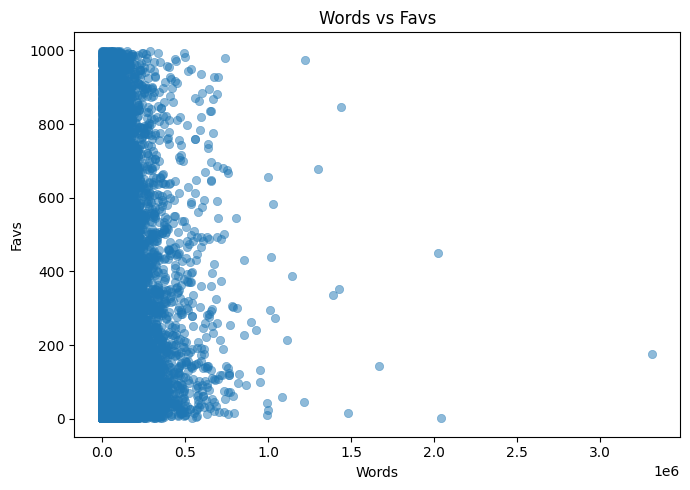

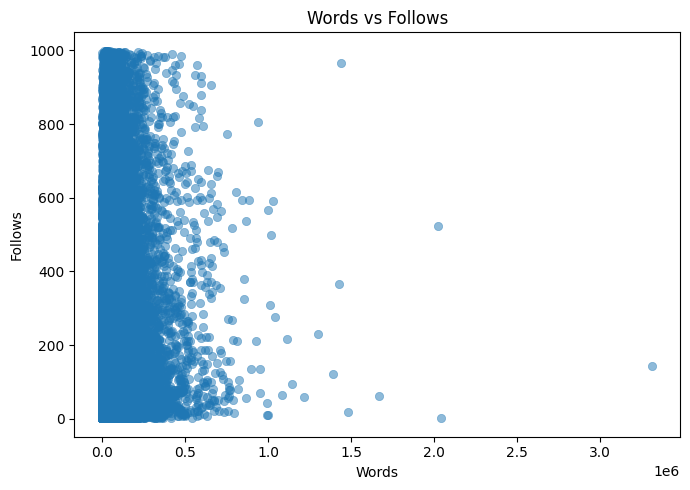

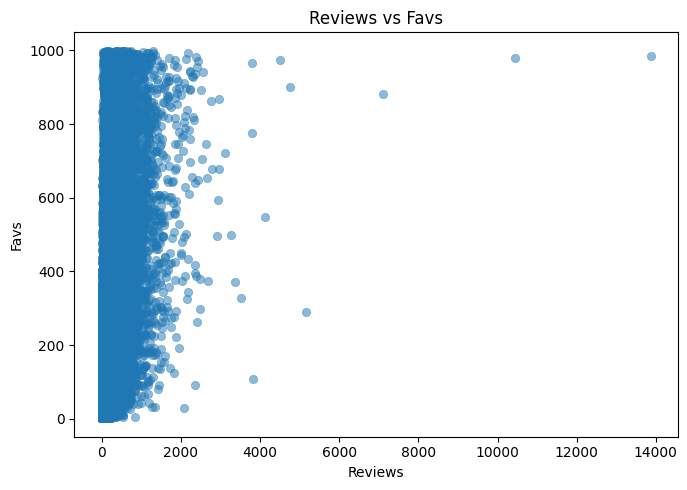

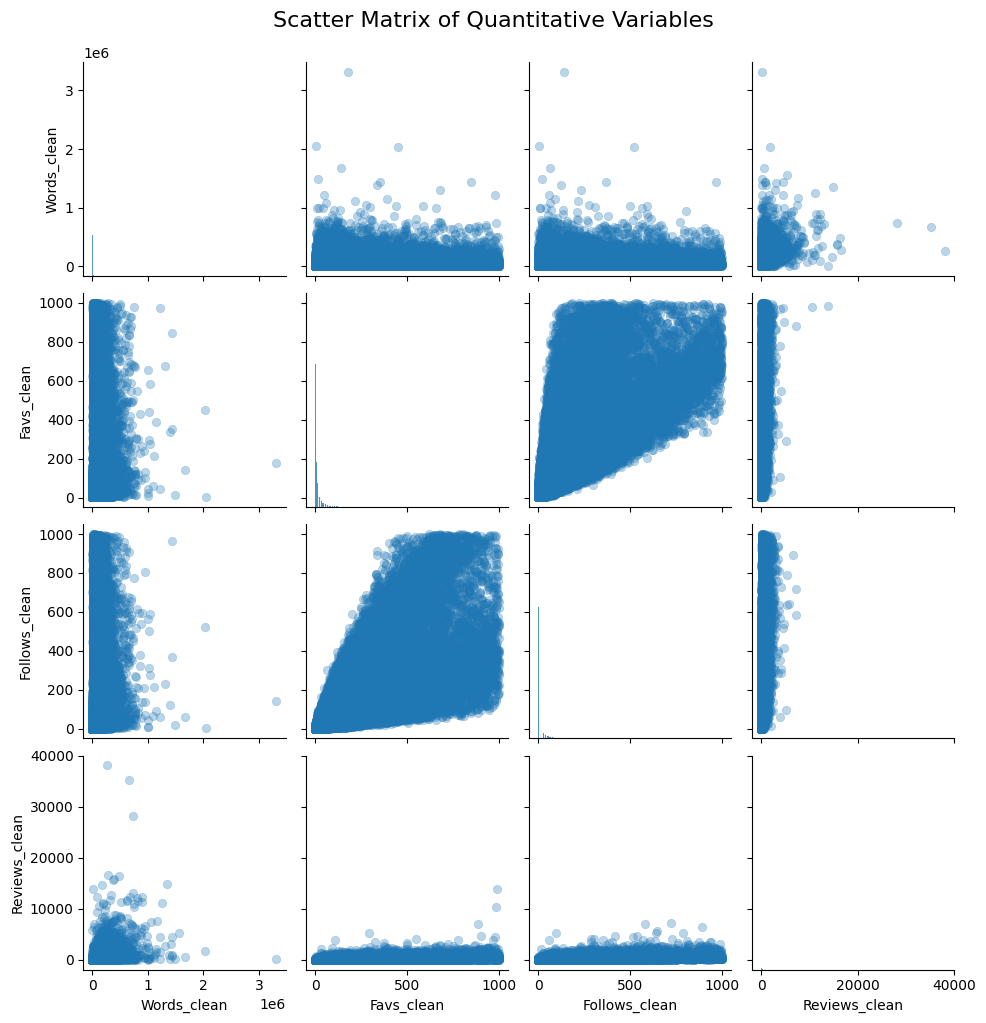

In [62]:
# TODO: Create scatter plots to explore relationships between quantitative variables
# Hint: Use seaborn's scatterplot() or pairplot()
# Focus on key relationships like: words vs reviews, favorites vs follows, words vs favorites
# Look for potential non-linear patterns that might benefit from polynomial terms

import seaborn as sns
import matplotlib.pyplot as plt

# Select core cleaned quantitative variables if available
quant_vars = [
    "Words_clean", "Favs_clean", "Follows_clean", "Reviews_clean"
]
# If not present in the DataFrame, fallback to originals without "_clean"
for var in quant_vars[:]:
    if var not in hp.columns:
        quant_vars.remove(var)
if not quant_vars:  # extreme fallback
    quant_vars = ["Words", "Favs", "Follows", "Reviews"]

print("Quantitative variables for scatter plots:", quant_vars)

# TODO: Focus on key relationships with targeted scatter plots
scatter_pairs = [
    ("Words_clean", "Reviews_clean"),
    ("Favs_clean", "Follows_clean"),
    ("Words_clean", "Favs_clean"),
    ("Words_clean", "Follows_clean"),
    ("Reviews_clean", "Favs_clean"),
]
scatter_pairs = [(x, y) for (x, y) in scatter_pairs if x in hp.columns and y in hp.columns]

for x, y in scatter_pairs:
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=hp[x], y=hp[y], alpha=0.5, edgecolor=None)
    plt.xlabel(x.replace("_clean", "").title())
    plt.ylabel(y.replace("_clean", "").title())
    plt.title(f"{x.replace('_clean', '').title()} vs {y.replace('_clean', '').title()}")
    plt.tight_layout()
    plt.show()

# TODO: Also provide a pairplot for an overview of all inter-variable relationships
sns.pairplot(hp[quant_vars], plot_kws={'alpha':0.3, 'edgecolor':None})
plt.suptitle("Scatter Matrix of Quantitative Variables", y=1.02, fontsize=16)
plt.show()
    

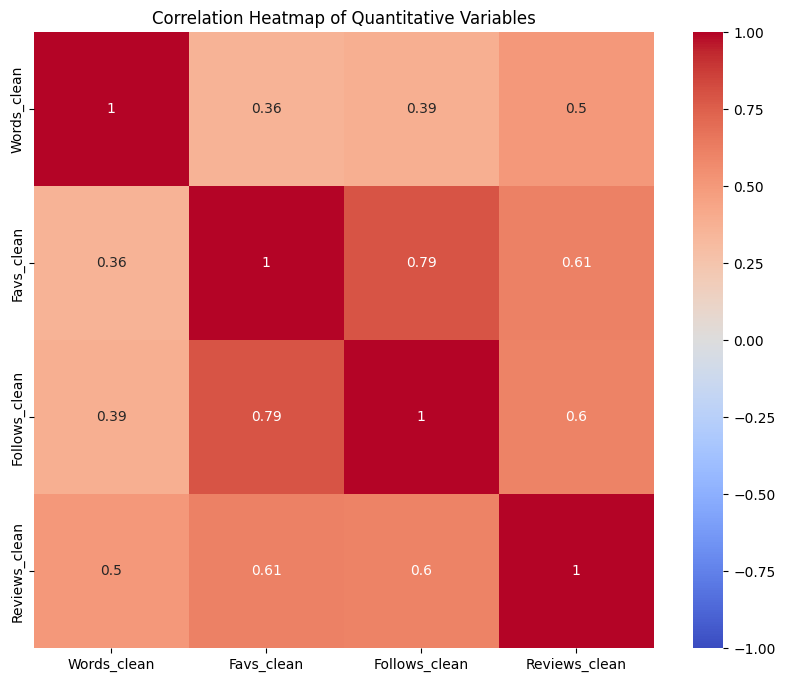

In [63]:
# TODO: Generate a correlation heatmap for quantitative variables
# Hint: Use pandas' .corr() method to calculate correlations, then seaborn's heatmap() to visualize
# Consider adding annotations to show correlation values

corr = hp[quant_vars].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Quantitative Variables")
plt.show()


### Reflection Questions:
1. What patterns do you notice in the distributions? Are there any variables with skewed distributions?
2. Which quantitative variables seem most correlated with each other?
3. Are there any relationships that look non-linear (curved rather than straight)?
4. How balanced are the binary variables? Are some characters more common than others?


## Phase 4: Target Variable Creation

Logistic regression requires a binary outcome variable. Since we want to predict story popularity, we need to define what makes a story "popular" based on the engagement metrics available (favorites, follows, reviews).

**Think about it:** What would make a fan fiction story popular? High number of favorites? Many followers? Lots of reviews? A combination of these?


In [64]:
# TODO: Explore the distribution of engagement metrics
# Hint: Look at the distribution of favorites, follows, and reviews
# Consider using box plots or violin plots to understand the spread
# This will help you decide on a reasonable threshold for "popularity"

print("What makes a story pouplar would be the sum of favorites, follows and reviews,\n that's why we will create a 'total_engagement' variable that will be our target variable.")

hp['total_engagement'] = hp['Favs_clean'] + hp['Follows_clean'] + hp['Reviews_clean']

What makes a story pouplar would be the sum of favorites, follows and reviews,
 that's why we will create a 'total_engagement' variable that will be our target variable.


In [65]:
# TODO: Create a binary target variable for story popularity
# Hint: You can use a threshold approach (e.g., stories above median favorites)
# Or create a composite score combining multiple metrics
# Name your target variable 'is_popular' (1 = popular, 0 = not popular)
# Consider using np.where() or boolean indexing

#Let's define is popular considering the quatile 0.75 of the total_engagement variable
hp['is_popular'] = np.where(hp['total_engagement'] > hp['total_engagement'].quantile(0.75), 1, 0)
print(hp['is_popular'].value_counts())

is_popular
0    533415
1    115078
Name: count, dtype: int64


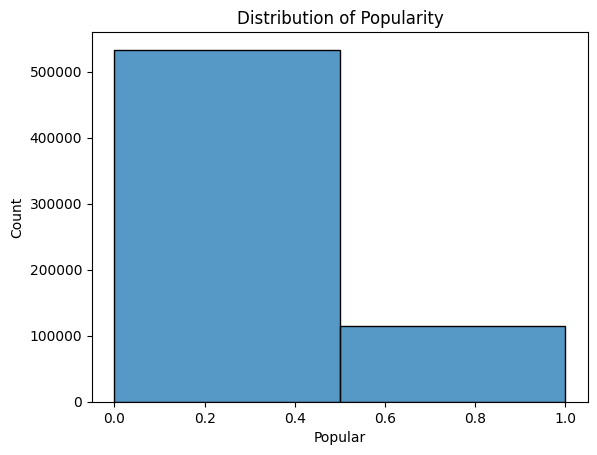

In [66]:
# TODO: Check the distribution of your target variable
# Hint: Use value_counts() to see how many stories are popular vs not popular
# Also create a count plot to visualize the balance
# Note: Perfect balance isn't required, but extreme imbalance (e.g., 95% in one class) can be problematic

# Write your code here:
sns.histplot(hp['is_popular'], bins=2, kde=False)
plt.title('Distribution of Popularity')
plt.xlabel('Popular')
plt.ylabel('Count')
plt.show()


## Phase 5: Feature Engineering - Interaction Terms

**What are interaction terms?** They capture how the effect of one variable depends on the value of another variable. For example:
- `harry × words`: Does the relationship between story length and popularity differ for Harry stories vs non-Harry stories?
- `words × reviews`: Do longer stories get more reviews, and does this affect popularity?

**Why do we need them?** Real-world relationships are often more complex than simple linear effects. Interaction terms help us model these complex relationships.


In [67]:
# TODO: Create interaction terms between binary and quantitative variables
# Hint: Multiply each binary variable (harry, hermione, multiple, english, humor) 
# with each quantitative variable (words, reviews, favorites, follows)
# Use simple multiplication: binary_var * quantitative_var
# Name them descriptively like 'harry_words', 'hermione_reviews', etc.

print("First check how hp looks like")
print(hp.columns)
# Columns: ['Chapters', 'Favs', 'Follows', 'Published', 'Reviews', 'Updated','Words', 'author', 
# 'characters', 'genre', 'language', 'rating', 'story_link', 'synopsis', 'title', 'published_mmyy', 'pairing',
# 'Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean', 'harry',
# 'hermione', 'ron', 'draco', 'multiple', 'english', 'humor', 'total_engagement', 'is_popular']

# Create log-transformed variables
hp['log_words'] = np.log1p(hp['Words_clean'])
hp['log_favs'] = np.log1p(hp['Favs_clean'])
hp['log_follows'] = np.log1p(hp['Follows_clean'])
hp['log_reviews'] = np.log1p(hp['Reviews_clean'])

# Potential binary vars


print(hp.head())

print("Now let's create the interaction terms")
print("Get rid of NaN values")
hp = hp.dropna()
nan_values = hp.isnull().sum()
print(nan_values)

print("Now let's create the interaction terms")

model_1 = sm.Logit.from_formula("is_popular ~ Words_clean + harry:hermione", data=hp).fit()
print(model_1.summary())

model2 = sm.Logit.from_formula("is_popular ~ Words_clean + harry:Words_clean", data=hp).fit()
print(model2.summary())

model3 = sm.Logit.from_formula("is_popular ~ Words_clean + hermione:Words_clean", data=hp).fit()
print(model3.summary())

# Test other character combinations
model_4 = sm.Logit.from_formula("is_popular ~ log_words + harry:draco", data=hp).fit()
model_5 = sm.Logit.from_formula("is_popular ~ log_words + ron:hermione", data=hp).fit()

# Test genre interactions
model_6 = sm.Logit.from_formula("is_popular ~ log_words + humor:log_words", data=hp).fit()
model_7 = sm.Logit.from_formula("is_popular ~ log_words + multiple:log_words", data=hp).fit()

# Test engagement metric interactions
model_8 = sm.Logit.from_formula("is_popular ~ log_words + log_favs + log_words:log_favs", data=hp).fit()
model_9 = sm.Logit.from_formula("is_popular ~ log_words + log_reviews + log_words:log_reviews", data=hp).fit()

# Add squared terms for non-linear relationships
hp['log_words_squared'] = hp['log_words'] ** 2
hp['log_favs_squared'] = hp['log_favs'] ** 2

model_10 = sm.Logit.from_formula("is_popular ~ log_words + log_words_squared", data=hp).fit()
model_11 = sm.Logit.from_formula("is_popular ~ log_words + log_favs_squared", data=hp).fit()

# Combine the best findings
comprehensive_model = sm.Logit.from_formula("""
    is_popular ~ log_words + log_favs + log_reviews + 
    harry + hermione + ron + draco + multiple + humor +
    harry:hermione + hermione:log_words + humor:log_words +
    log_words:log_favs
""", data=hp).fit()

print(model_4.summary())
print(model_5.summary())
print(model_6.summary())
print(model_7.summary())
print(model_8.summary())
print(model_9.summary())
print(model_10.summary())
print(model_11.summary())
print(comprehensive_model.summary())
















First check how hp looks like
Index(['Chapters', 'Favs', 'Follows', 'Published', 'Reviews', 'Updated',
       'Words', 'author', 'characters', 'genre', 'language', 'rating',
       'story_link', 'synopsis', 'title', 'published_mmyy', 'pairing',
       'Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean', 'harry',
       'hermione', 'ron', 'draco', 'multiple', 'english', 'humor',
       'total_engagement', 'is_popular'],
      dtype='object')
   Chapters Favs Follows    Published  Reviews Updated    Words  \
0         1    2     NaN   12/31/2019      1.0     NaN    6,840   
1         1    1     NaN   12/31/2019      NaN     NaN   10,962   
2         1    3       2   12/31/2019      NaN     NaN    8,592   
3         2  NaN     NaN   12/31/2019      NaN     NaN    7,260   
4         1    4       3   12/31/2019      NaN     NaN    1,529   

              author                                   characters  \
0            reviews    Sirius B., Remus L., James P., Regulus B.   
1   

In [68]:
# Remove engagement metrics from features
clean_model = sm.Logit.from_formula("""
    is_popular ~ log_words + harry + hermione + ron + draco + 
    multiple + humor + harry:hermione + humor:log_words
""", data=hp).fit()

print(clean_model.summary())

Optimization terminated successfully.
         Current function value: 0.490251
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:               123293
Model:                          Logit   Df Residuals:                   123283
Method:                           MLE   Df Model:                            9
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                  0.2817
Time:                        10:44:25   Log-Likelihood:                -60445.
converged:                       True   LL-Null:                       -84145.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.5788      0.089   -130.238      0.000     -11.753     -11.405
log_words     

In [69]:
# Test the model on new data
new_story_features = {
    'log_words': 8.5,  # ~4,900 words
    'harry': 1,
    'hermione': 0, 
    'ron': 0,
    'draco': 0,
    'multiple': 0,
    'humor': 1
}

# Predict popularity probability
probability = clean_model.predict(new_story_features)
print(f"Predicted popularity probability: {probability[0]:.2%}")

Predicted popularity probability: 64.74%


### Understanding Interaction Terms:
**Binary × Quantitative:** If `harry_words` has a positive coefficient, it means Harry stories benefit more from being longer than non-Harry stories.

**Quantitative × Quantitative:** If `words_reviews` has a positive coefficient, it means the effect of word count on popularity is stronger when there are more reviews.

**Binary × Binary:** If `harry_hermione` has a positive coefficient, it means stories with both Harry and Hermione are more popular than you'd expect from just adding their individual effects.


## Phase 6: Feature Engineering - Polynomial Terms

**What are polynomial terms?** They capture non-linear relationships. A quadratic (squared) term can model relationships that curve upward or downward.

**Why do we need them?** Sometimes the relationship between a variable and the outcome isn't straight-line. For example:
- Very short stories might be unpopular (too brief)
- Very long stories might also be unpopular (too long to read)
- Medium-length stories might be most popular (sweet spot)

This creates a curved (quadratic) relationship that linear terms alone can't capture.


In [70]:
# TODO: Create quadratic (squared) terms for quantitative variables
# Hint: Square each quantitative variable using ** 2 or np.square()
# Create: words_squared, reviews_squared, favorites_squared, follows_squared
# These will help capture non-linear relationships
# Checking types
# Square the quantitative variables to create polynomial terms
hp['log_words_squared'] = hp['log_words'] ** 2
hp['log_favs_squared'] = hp['log_favs'] ** 2
hp['log_follows_squared'] = hp['log_follows'] ** 2
hp['log_reviews_squared'] = hp['log_reviews'] ** 2




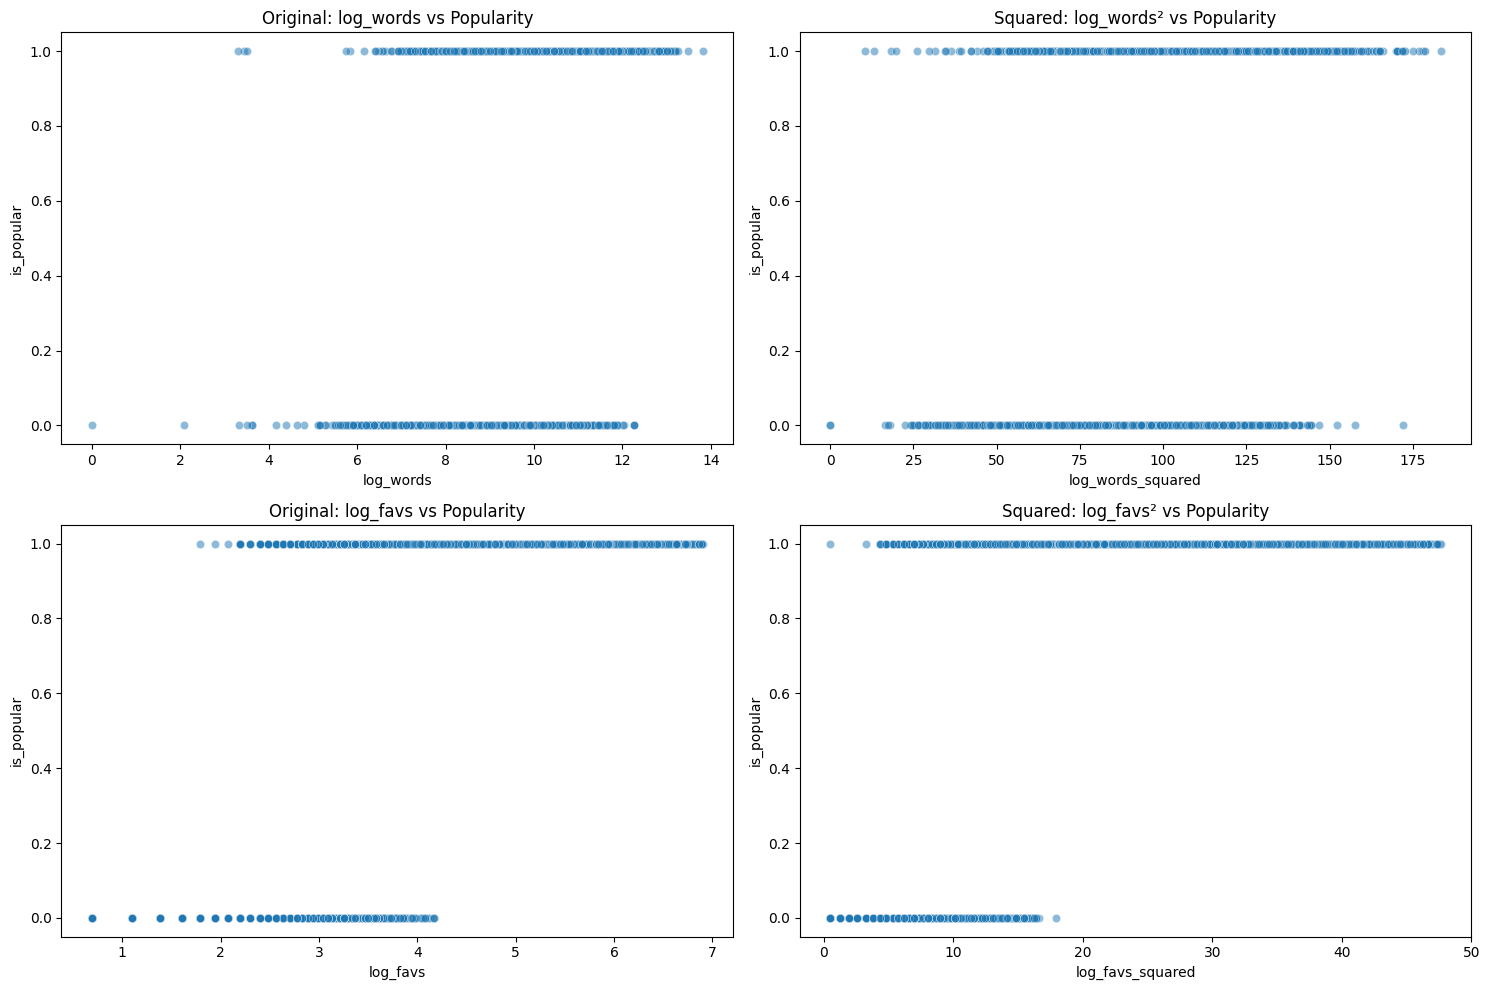

In [71]:
# TODO: (Optional) Visualize original vs squared relationships
# Hint: Create scatter plots showing the relationship between original variables and target
# Then show the same for squared variables
# This can help you see if the quadratic terms are capturing important patterns

# Compare original vs squared relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original relationship: log_words vs is_popular
sns.scatterplot(x="log_words", y="is_popular", data=hp.sample(10000), alpha=0.5, ax=axes[0,0])
axes[0,0].set_title("Original: log_words vs Popularity")

# Squared relationship: log_words_squared vs is_popular  
sns.scatterplot(x="log_words_squared", y="is_popular", data=hp.sample(10000), alpha=0.5, ax=axes[0,1])
axes[0,1].set_title("Squared: log_words² vs Popularity")

# Original: log_favs vs is_popular
sns.scatterplot(x="log_favs", y="is_popular", data=hp.sample(10000), alpha=0.5, ax=axes[1,0])
axes[1,0].set_title("Original: log_favs vs Popularity")

# Squared: log_favs_squared vs is_popular
sns.scatterplot(x="log_favs_squared", y="is_popular", data=hp.sample(10000), alpha=0.5, ax=axes[1,1])
axes[1,1].set_title("Squared: log_favs² vs Popularity")

plt.tight_layout()
plt.show()

## Phase 7: Model Building with StatsModels

StatsModels provides detailed statistical output that's great for understanding your model. It gives you p-values, confidence intervals, and detailed diagnostics that help with interpretation.

**Key difference:** StatsModels requires you to explicitly add a constant term (intercept) to your feature matrix.


In [72]:
# TODO: Prepare your feature matrix and target variable
# Hint: Create a DataFrame or array containing all your features:
# - Original quantitative variables (words, reviews, favorites, follows)
# - Original binary variables (harry, hermione, multiple, english, humor)
# - All interaction terms you created
# - All polynomial terms you created
# Make sure to exclude the target variable from your features!

# TODO: Build multiple models to compare different approaches
# Compare models with different feature combinations

# Model 1: Only original features (baseline)
baseline_model = sm.Logit.from_formula("""
    is_popular ~ log_words + harry + hermione + ron + draco + multiple + humor
""", data=hp).fit()

# Model 2: With interaction terms
interaction_model = sm.Logit.from_formula("""
    is_popular ~ log_words + harry + hermione + ron + draco + multiple + humor +
    harry:hermione + humor:log_words
""", data=hp).fit()

# Model 3: With polynomial terms
polynomial_model = sm.Logit.from_formula("""
    is_popular ~ log_words + log_words_squared + harry + hermione + ron + draco + multiple + humor
""", data=hp).fit()

# Model 4: Your comprehensive model (from Phase 5)
comprehensive_model = sm.Logit.from_formula("""
    is_popular ~ log_words + harry + hermione + ron + draco + multiple + humor +
    harry:hermione + humor:log_words
""", data=hp).fit()

print("Baseline Model:")
print(baseline_model.summary())
print("\nInteraction Model:")
print(interaction_model.summary())
print("\nPolynomial Model:")
print(polynomial_model.summary())
print("\nComprehensive Model:")
print(comprehensive_model.summary())


Optimization terminated successfully.
         Current function value: 0.496141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490251
         Iterations 6
Baseline Model:
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:               123293
Model:                          Logit   Df Residuals:                   123285
Method:                           MLE   Df Model:                            7
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                  0.2730
Time:                        10:44:31   Log-Likelihood:                -61171.
converged:                       True   LL-Null:                       -84145.
Covariance Type:       

In [73]:
# TODO: Compare model performance metrics
models = {
    'Baseline': baseline_model,
    'Interaction': interaction_model, 
    'Polynomial': polynomial_model,
    'Comprehensive': comprehensive_model
}

comparison_results = []
for name, model in models.items():
    comparison_results.append({
        'Model': name,
        'Pseudo_R2': model.prsquared,
        'Log_Likelihood': model.llf,
        'AIC': model.aic,
        'BIC': model.bic,
        'N_Features': len(model.params) - 1  # Exclude intercept
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

           Model  Pseudo_R2  Log_Likelihood            AIC            BIC  \
0       Baseline   0.273031   -61170.714893  122357.429786  122435.208337   
1    Interaction   0.281662   -60444.501774  120909.003547  121006.226737   
2     Polynomial   0.274758   -61025.409617  122068.819235  122156.320105   
3  Comprehensive   0.281662   -60444.501774  120909.003547  121006.226737   

   N_Features  
0           7  
1           9  
2           8  
3           9  


In [74]:
# TODO: Analyze which features are most important
# Extract coefficients and p-values from your comprehensive model
feature_analysis = pd.DataFrame({
    'Feature': comprehensive_model.params.index,
    'Coefficient': comprehensive_model.params.values,
    'P_Value': comprehensive_model.pvalues.values,
    'Significant': comprehensive_model.pvalues < 0.05
})

# Sort by absolute coefficient value
feature_analysis['Abs_Coefficient'] = abs(feature_analysis['Coefficient'])
feature_analysis = feature_analysis.sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance Analysis:")
print(feature_analysis[['Feature', 'Coefficient', 'P_Value', 'Significant']])

Feature Importance Analysis:
                         Feature  Coefficient        P_Value  Significant
Intercept              Intercept   -11.578771   0.000000e+00         True
harry                      harry     1.471933   0.000000e+00         True
harry:hermione    harry:hermione    -1.366178   0.000000e+00         True
hermione                hermione     1.360352   0.000000e+00         True
log_words              log_words     1.220637   0.000000e+00         True
multiple                multiple    -1.100868  1.139811e-101         True
ron                          ron    -0.663559   1.080178e-94         True
draco                      draco    -0.252770   4.916523e-55         True
humor                      humor     0.099898   5.508277e-01        False
humor:log_words  humor:log_words     0.028147   1.157325e-01        False


### Interpreting StatsModels Output:
1. **Coefficients:** Show the log-odds change for a 1-unit increase in the predictor
2. **P-values:** Indicate statistical significance (typically < 0.05)
3. **Pseudo R-squared:** Measures model fit (higher is better, but don't expect values as high as in linear regression)
4. **Log-likelihood:** Used for model comparison (higher is better)

**Key insight:** Positive coefficients increase the probability of the outcome, negative coefficients decrease it.


## Phase 8: Model Building with scikit-learn

Scikit-learn is more focused on prediction and machine learning workflows. It's often easier to use for model evaluation and comparison, but provides less detailed statistical output.

**Key differences from StatsModels:**
- Automatically handles the intercept (no need to add constant)
- Built-in train/test split and cross-validation tools
- More machine learning focused (prediction vs. inference)


In [79]:
# TODO: Split your data into training and testing sets
# Hint: Use train_test_split() from sklearn.model_selection
# Use a reasonable test size (e.g., 0.2 or 0.3)
# Set random_state for reproducibility
# Remember: you need to split both features and target

# TODO: Split your data into training and testing sets
# Step 1: Check your data first
print("Available columns:")
print(hp.columns.tolist())

print("\nData types:")
print(hp.dtypes)

# Step 2: Select only the numeric features you want
feature_columns = ['log_words', 'harry', 'hermione', 'ron', 'draco', 'multiple', 'humor']

# Verify these columns exist and are numeric
print(f"\nChecking feature columns:")
for col in feature_columns:
    if col in hp.columns:
        print(f"✅ {col}: {hp[col].dtype} - {hp[col].dtype in ['int64', 'float64', 'int32', 'float32']}")
    else:
        print(f"❌ {col}: NOT FOUND")

# Step 3: Create feature matrix (only numeric columns)
X = hp[feature_columns].copy()
y = hp['is_popular'].copy()

# Step 4: Check for any remaining issues
print(f"\nFeature matrix shape: {X.shape}")
print(f"Feature matrix dtypes:\n{X.dtypes}")
print(f"Any missing values: {X.isnull().sum().sum()}")

# Step 5: Remove rows with missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"After removing missing values:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Step 6: Now split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

print(f"\nSplit successful!")
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")



Available columns:
['Chapters', 'Favs', 'Follows', 'Published', 'Reviews', 'Updated', 'Words', 'author', 'characters', 'genre', 'language', 'rating', 'story_link', 'synopsis', 'title', 'published_mmyy', 'pairing', 'Words_clean', 'Favs_clean', 'Follows_clean', 'Reviews_clean', 'harry', 'hermione', 'ron', 'draco', 'multiple', 'english', 'humor', 'total_engagement', 'is_popular', 'log_words', 'log_favs', 'log_follows', 'log_reviews', 'log_words_squared', 'log_favs_squared', 'log_follows_squared', 'log_reviews_squared']

Data types:
Chapters                 int64
Favs                    object
Follows                 object
Published               object
Reviews                float64
Updated                 object
Words                   object
author                  object
characters              object
genre                   object
language                object
rating                  object
story_link              object
synopsis                object
title                   object


In [80]:
# TODO: Fit a logistic regression model using scikit-learn
# Hint: Import LogisticRegression from sklearn.linear_model
# Create a model instance and fit it on your training data
# Note: You don't need to add a constant term - sklearn handles this automatically

import sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [82]:
# TODO: Make predictions on the test set
# Hint: Use .predict() for binary predictions (0 or 1)
# Use .predict_proba() to get probability scores
# Store both types of predictions

# Write your code here:
predictions = model.predict(X_test)
predictions_scores = model.predict_proba(X_test)

print("Predictions: ", predictions_scores)


Predictions:  [[0.3046445  0.6953555 ]
 [0.93031557 0.06968443]
 [0.83305479 0.16694521]
 ...
 [0.77436129 0.22563871]
 [0.38272925 0.61727075]
 [0.37028309 0.62971691]]


Accuracy: 0.76
Confusion Matrix:
[[11557  2570]
 [ 3374  7158]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80     14127
           1       0.74      0.68      0.71     10532

    accuracy                           0.76     24659
   macro avg       0.75      0.75      0.75     24659
weighted avg       0.76      0.76      0.76     24659

ROC AUC: 0.83


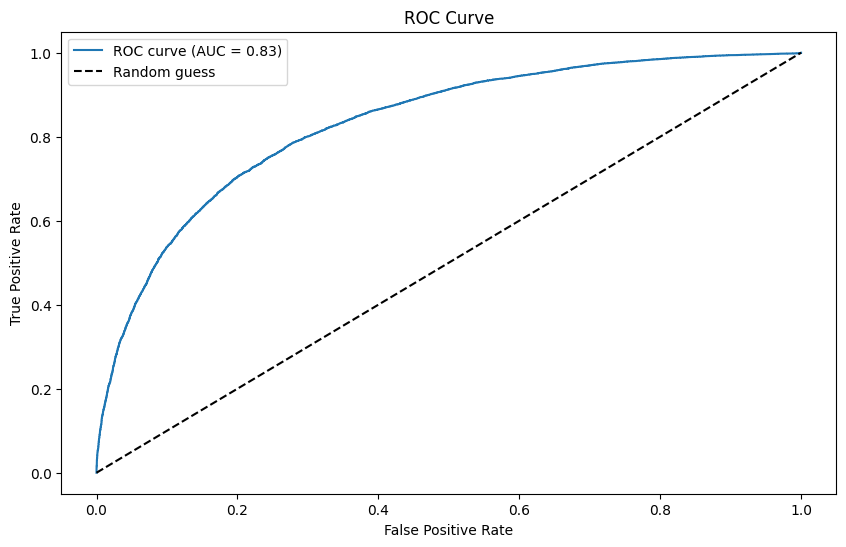

In [84]:
# TODO: Evaluate your model performance
# Hint: Import evaluation metrics from sklearn.metrics
# Calculate: accuracy_score, confusion_matrix, classification_report
# Also consider: roc_auc_score, precision_score, recall_score, f1_score

# Write your code here:
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print(f"Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, predictions)
print(f"Classification Report:")
print(class_report)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions_scores[:, 1])

roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



### Comparing StatsModels vs scikit-learn:
1. **StatsModels:** Better for understanding relationships, hypothesis testing, detailed statistics
2. **scikit-learn:** Better for prediction, model comparison, machine learning workflows
3. **Coefficients:** Should be similar between both approaches (except for the intercept handling)
4. **Use both:** StatsModels for interpretation, scikit-learn for evaluation and comparison


## Phase 9: Model Comparison and Interpretation

Now let's compare different models to understand the value of interaction and polynomial terms. We'll build a baseline model with only original features and compare it to our full model.


In [85]:
# TODO: Build a baseline model with only original features (no interactions or polynomials)
# Hint: Use only the original quantitative and binary variables
# Fit this model using both StatsModels and scikit-learn
# This will help you see the improvement from adding interaction and polynomial terms

# Write your code here:
model_baseline_sm = sm.Logit.from_formula("""
    is_popular ~ log_words + harry + hermione + ron + draco + multiple + humor
""", data=hp).fit()

model_baseline_sk = LogisticRegression()
model_baseline_sk.fit(X_train, y_train)

print(model_baseline_sm.summary())
print(model_baseline_sk.coef_)



Optimization terminated successfully.
         Current function value: 0.496141
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_popular   No. Observations:               123293
Model:                          Logit   Df Residuals:                   123285
Method:                           MLE   Df Model:                            7
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                  0.2730
Time:                        12:26:12   Log-Likelihood:                -61171.
converged:                       True   LL-Null:                       -84145.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.3182      0.080   -141.151      0.000     -11.475     -11.161
log_words      1.2068      0.

In [88]:
from sklearn.metrics import roc_auc_score

y_pred = model_baseline_sk.predict(X_test)
y_pred_proba = model_baseline_sk.predict_proba(X_test)

# Create a comprehensive scikit-learn summary
def create_sklearn_summary(model, X, y_test, y_pred):
    """
    Create a comprehensive summary similar to StatsModels
    """
    # Feature coefficients
    feature_names = X.columns.tolist()
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]
    
    print("=" * 60)
    print("SCIKIT-LEARN LOGISTIC REGRESSION SUMMARY")
    print("=" * 60)
    
    print(f"Intercept: {intercept:.6f}")
    print("\nFeature Coefficients:")
    print("-" * 30)
    
    for name, coef in zip(feature_names, coefficients):
        print(f"{name:15}: {coef:8.6f}")
    
    print("\nModel Performance:")
    print("-" * 30)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
    
    return None

# Use it
create_sklearn_summary(model, X, y_test, y_pred)

SCIKIT-LEARN LOGISTIC REGRESSION SUMMARY
Intercept: -11.355427

Feature Coefficients:
------------------------------
log_words      : 1.212057
harry          : 1.111505
hermione       : 0.953154
ron            : -0.645340
draco          : -0.103047
multiple       : -1.099460
humor          : 0.343753

Model Performance:
------------------------------
Accuracy: 0.759
AUC: 0.831


      Metric  Statsmodels  Scikit-learn
0   Accuracy     0.273031      0.758952
1        AUC     0.831259      0.831225
2  Precision     0.735814      0.735814
3     Recall     0.679643      0.679643
4   F1-Score     0.706614      0.706614


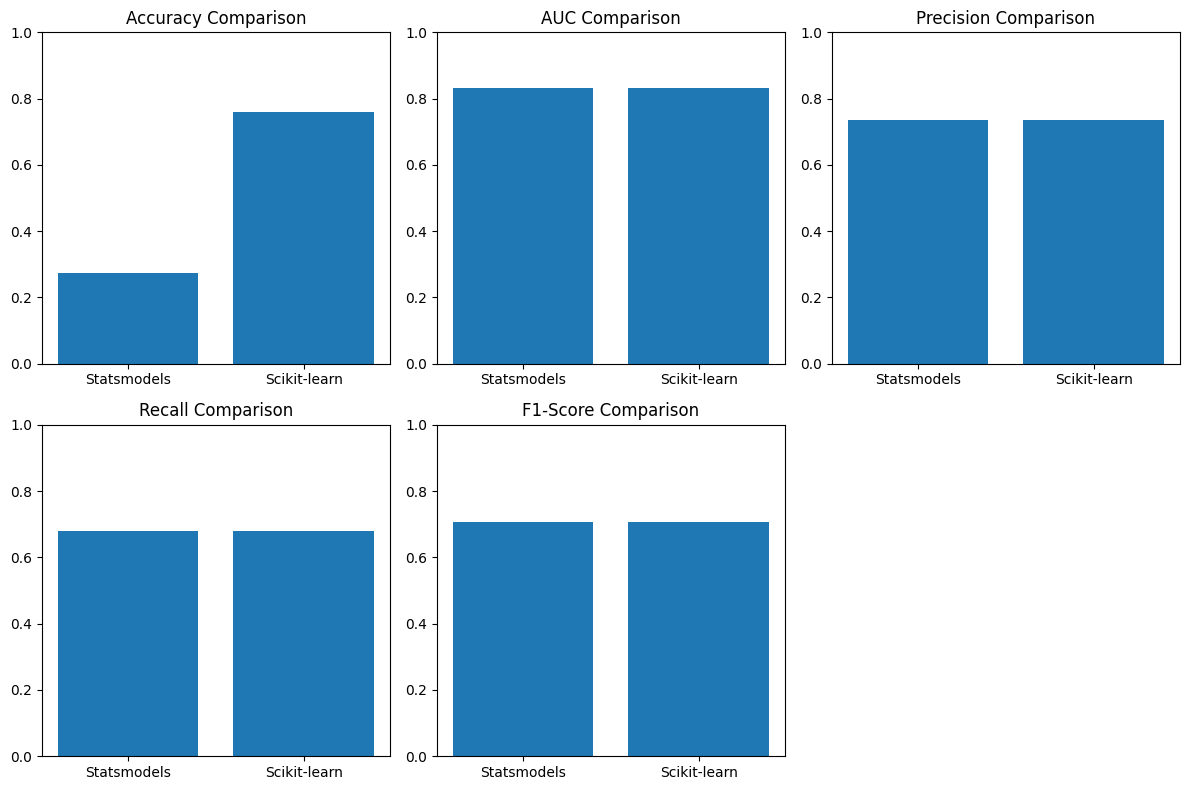

In [90]:
# TODO: Compare model performance metrics
# Hint: Calculate the same evaluation metrics for both baseline and full models
# Compare: accuracy, AUC, precision, recall, F1-score
# Create a comparison table or summary
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Statsmodels metrics
accuracy_sm = model_baseline_sm.prsquared
auc_sm = roc_auc_score(y_test, model_baseline_sm.predict(X_test))
f1_sm = f1_score(y_test, y_pred)
precision_sm = precision_score(y_test, y_pred)
recall_sm = recall_score(y_test, y_pred)

# Scikit-learn metrics
accuracy_sk = accuracy_score(y_test, y_pred)
auc_sk = roc_auc_score(y_test, y_pred_proba[:, 1])
f1_sk = f1_score(y_test, y_pred)
precision_sk = precision_score(y_test, y_pred)
recall_sk = recall_score(y_test, y_pred)

# Comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1-Score'],
    'Statsmodels': [accuracy_sm, auc_sm, precision_sm, recall_sm, f1_sm],
    'Scikit-learn': [accuracy_sk, auc_sk, precision_sk, recall_sk, f1_sk]
})
print(comparison_table)

# Plot comparison
plt.figure(figsize=(12, 8))

# Plot accuracy
plt.subplot(2, 3, 1)
plt.bar(['Statsmodels', 'Scikit-learn'], [accuracy_sm, accuracy_sk])
plt.title('Accuracy Comparison')
plt.ylim(0, 1)

# Plot AUC
plt.subplot(2, 3, 2)
plt.bar(['Statsmodels', 'Scikit-learn'], [auc_sm, auc_sk])
plt.title('AUC Comparison')
plt.ylim(0, 1)

# Plot precision
plt.subplot(2, 3, 3)
plt.bar(['Statsmodels', 'Scikit-learn'], [precision_sm, precision_sk])
plt.title('Precision Comparison')
plt.ylim(0, 1)

# Plot recall
plt.subplot(2, 3, 4)
plt.bar(['Statsmodels', 'Scikit-learn'], [recall_sm, recall_sk])
plt.title('Recall Comparison')
plt.ylim(0, 1)

# Plot F1-score
plt.subplot(2, 3, 5)
plt.bar(['Statsmodels', 'Scikit-learn'], [f1_sm, f1_sk])
plt.title('F1-Score Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()








In [96]:
# TODO: Identify the most significant interaction and polynomial terms
# Hint: Look at the coefficients and p-values from your StatsModels output
# Find terms with large coefficients and small p-values
# Consider creating a summary of the top 5-10 most important terms

def create_interaction_summary_statsmodels(model, model_name="Model"):
    """
    Create a summary of the most significant interaction and polynomial terms from StatsModels
    """
    print(f"\n{'='*60}")
    print(f"MOST SIGNIFICANT TERMS - {model_name.upper()}")
    print(f"{'='*60}")
    
    # Get all terms with their coefficients and p-values
    terms_data = []
    for term in model.params.index:
        if term != 'Intercept':  # Skip intercept
            terms_data.append({
                'Term': term,
                'Coefficient': model.params[term],
                'P_Value': model.pvalues[term],
                'Abs_Coefficient': abs(model.params[term]),
                'Significant': model.pvalues[term] < 0.05
            })
    
    # Create DataFrame and sort by absolute coefficient
    terms_df = pd.DataFrame(terms_data)
    terms_df = terms_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Identify interaction and polynomial terms
    interaction_terms = terms_df[terms_df['Term'].str.contains(':')]
    polynomial_terms = terms_df[terms_df['Term'].str.contains('_squared|^2')]
    
    print(f"\nTOP 10 MOST IMPORTANT TERMS (by |coefficient|):")
    print("-" * 80)
    print(f"{'Term':<25} {'Coefficient':<12} {'P-Value':<10} {'Significant':<12}")
    print("-" * 80)
    
    for _, row in terms_df.head(10).iterrows():
        sig_mark = "***" if row['Significant'] else "   "
        print(f"{row['Term']:<25} {row['Coefficient']:<12.6f} {row['P_Value']:<10.6f} {sig_mark}")
    
    if len(interaction_terms) > 0:
        print(f"\nINTERACTION TERMS:")
        print("-" * 50)
        for _, row in interaction_terms.iterrows():
            sig_mark = "***" if row['Significant'] else "   "
            print(f"{row['Term']:<25} {row['Coefficient']:<12.6f} {sig_mark}")
    
    if len(polynomial_terms) > 0:
        print(f"\nPOLYNOMIAL TERMS:")
        print("-" * 50)
        for _, row in polynomial_terms.iterrows():
            sig_mark = "***" if row['Significant'] else "   "
            print(f"{row['Term']:<25} {row['Coefficient']:<12.6f} {sig_mark}")
    
    return terms_df

def create_interaction_summary_sklearn(model, X, y_test, y_pred, model_name="Model"):
    """
    Create a summary of the most significant terms from scikit-learn
    """
    print(f"\n{'='*60}")
    print(f"MOST SIGNIFICANT TERMS - {model_name.upper()} (SCIKIT-LEARN)")
    print(f"{'='*60}")
    
    # Get feature names and coefficients
    if hasattr(X, 'columns'):
        feature_names = list(X.columns)
    else:
        feature_names = [f'feature_{i}' for i in range(len(model.coef_[0]))]
    
    # Create terms data
    terms_data = []
    for name, coef in zip(feature_names, model.coef_[0]):
        terms_data.append({
            'Term': name,
            'Coefficient': coef,
            'Abs_Coefficient': abs(coef)
        })
    
    # Create DataFrame and sort by absolute coefficient
    terms_df = pd.DataFrame(terms_data)
    terms_df = terms_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Identify interaction and polynomial terms
    interaction_terms = terms_df[terms_df['Term'].str.contains(':')]
    polynomial_terms = terms_df[terms_df['Term'].str.contains('_squared|^2')]
    
    print(f"\nTOP 10 MOST IMPORTANT TERMS (by |coefficient|):")
    print("-" * 60)
    print(f"{'Term':<25} {'Coefficient':<12}")
    print("-" * 60)
    
    for _, row in terms_df.head(10).iterrows():
        print(f"{row['Term']:<25} {row['Coefficient']:<12.6f}")
    
    if len(interaction_terms) > 0:
        print(f"\nINTERACTION TERMS:")
        print("-" * 40)
        for _, row in interaction_terms.iterrows():
            print(f"{row['Term']:<25} {row['Coefficient']:<12.6f}")
    
    if len(polynomial_terms) > 0:
        print(f"\nPOLYNOMIAL TERMS:")
        print("-" * 40)
        for _, row in polynomial_terms.iterrows():
            print(f"{row['Term']:<25} {row['Coefficient']:<12.6f}")
    
    return terms_df

# Use the functions with your models
print("ANALYZING MOST SIGNIFICANT TERMS")
print("="*80)

# For StatsModels - use your interaction model (the best one)
stats_terms = create_interaction_summary_statsmodels(interaction_model, "Interaction Model")

# For scikit-learn
sklearn_terms = create_interaction_summary_sklearn(model, X, y_test, y_pred, "Scikit-learn Model")

# Compare the results
print(f"\n{'='*60}")
print("COMPARISON SUMMARY")
print(f"{'='*60}")

print(f"\nStatsModels Top 5 Terms:")
for _, row in stats_terms.head(5).iterrows():
    print(f"  {row['Term']:<20}: {row['Coefficient']:8.6f} (p={row['P_Value']:.6f})")

print(f"\nScikit-learn Top 5 Terms:")
for _, row in sklearn_terms.head(5).iterrows():
    print(f"  {row['Term']:<20}: {row['Coefficient']:8.6f}")

ANALYZING MOST SIGNIFICANT TERMS

MOST SIGNIFICANT TERMS - INTERACTION MODEL

TOP 10 MOST IMPORTANT TERMS (by |coefficient|):
--------------------------------------------------------------------------------
Term                      Coefficient  P-Value    Significant 
--------------------------------------------------------------------------------
harry                     1.471933     0.000000   ***
harry:hermione            -1.366178    0.000000   ***
hermione                  1.360352     0.000000   ***
log_words                 1.220637     0.000000   ***
multiple                  -1.100868    0.000000   ***
ron                       -0.663559    0.000000   ***
draco                     -0.252770    0.000000   ***
humor                     0.099898     0.550828      
humor:log_words           0.028147     0.115732      

INTERACTION TERMS:
--------------------------------------------------
harry:hermione            -1.366178    ***
humor:log_words           0.028147        

MOST 

### Key Questions to Consider:
1. **Which features matter most?** Look at the largest coefficients (in absolute value)
2. **Are interactions helpful?** Compare baseline vs full model performance
3. **Do polynomial terms capture important patterns?** Check if squared terms are significant
4. **What makes a story popular?** Interpret the most significant coefficients in real-world terms

**Example interpretation:** If `harry_words` has a positive coefficient, it means Harry stories benefit more from being longer than non-Harry stories.


## Phase 10: Visualization of Results

Visualizing your model results helps you understand performance and communicate findings effectively. Good visualizations can reveal patterns that numbers alone might miss.


In [30]:
# TODO: Create ROC curve and calculate AUC
# Hint: Use roc_curve() and auc() from sklearn.metrics
# Plot the ROC curve using matplotlib
# The AUC (Area Under Curve) measures how well your model separates the classes
# AUC = 0.5 is random, AUC = 1.0 is perfect

# Write your code here:


In [31]:
# TODO: Visualize predicted probabilities distribution
# Hint: Create histograms of predicted probabilities for each class (popular vs not popular)
# Use your model's .predict_proba() output
# This shows how confident your model is in its predictions

# Write your code here:


In [32]:
# TODO: Create a feature importance visualization
# Hint: Plot the coefficients from your model (absolute values)
# Focus on the top 10-15 most important features
# Use a horizontal bar plot for easy reading
# This helps identify which features drive predictions most

# Write your code here:


In [33]:
# TODO: Create a confusion matrix heatmap
# Hint: Use seaborn's heatmap() to visualize your confusion matrix
# Add annotations to show the actual numbers
# This helps you see where your model makes mistakes

# Write your code here:


## Phase 11: Conclusion and Reflection

Congratulations! You've completed a comprehensive logistic regression analysis with interaction and polynomial terms. Let's reflect on what you've learned and discovered.


### Reflection Questions:

1. **Model Performance:** How well did your model perform? What was your final accuracy and AUC?

2. **Feature Importance:** Which features were most important for predicting story popularity? Did this match your initial expectations?

3. **Interaction Terms:** Which interaction terms were most significant? What do they tell you about how different story characteristics work together?

4. **Polynomial Terms:** Were any quadratic terms significant? What non-linear relationships did they capture?

5. **Model Comparison:** How much did interaction and polynomial terms improve your model compared to the baseline?

6. **Real-world Insights:** What insights can you draw about what makes Harry Potter fan fiction popular? Are there any surprising findings?

7. **Limitations:** What are the limitations of your analysis? What other factors might affect story popularity that aren't in your dataset?

8. **Next Steps:** If you were to continue this analysis, what would you do next? Consider:
   - Regularization (L1/L2) to handle overfitting
   - Feature selection to identify the most important predictors
   - Cross-validation for more robust performance estimates
   - Other algorithms (Random Forest, XGBoost) for comparison


### Key Learning Takeaways:

✅ **Interaction Terms:** You learned how to create and interpret interaction terms that capture how variables work together

✅ **Polynomial Terms:** You discovered how quadratic terms can capture non-linear relationships

✅ **StatsModels vs scikit-learn:** You compared two different approaches to logistic regression and understood their strengths

✅ **Model Interpretation:** You learned to interpret coefficients, p-values, and model performance metrics

✅ **Feature Engineering:** You practiced creating new features from existing ones to improve model performance

✅ **Real-world Application:** You applied these techniques to a realistic dataset with complex relationships


### Congratulations! 🎉

You've successfully completed a comprehensive logistic regression analysis with advanced feature engineering techniques. These skills will serve you well in future machine learning projects where you need to model complex relationships in your data.

**Remember:** The goal isn't just to build a model, but to understand the relationships in your data and extract meaningful insights that can inform real-world decisions.
